In [1]:
import os
import sys
import time
import json
import re
import ast
import fitz  # PyMuPDF
import faiss
import numpy as np
import pandas as pd
import torch
import nltk
import spacy
import praw
import fitz
import nest_asyncio
import asyncio
import matplotlib.pyplot as plt
import seaborn as sns
from crawl4ai import AsyncWebCrawler
from crawl4ai.async_configs import BrowserConfig, CrawlerRunConfig
from tqdm import tqdm
from collections import Counter
from datetime import datetime, timezone
from psaw import PushshiftAPI
from nltk.corpus import stopwords
from google.cloud import storage, aiplatform
from transformers import AutoModelForCausalLM, AutoTokenizer
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import FAISS, Chroma
from langchain.llms import VertexAI
from langchain.chains import RetrievalQA
from langchain.document_loaders import TextLoader, PyMuPDFLoader
from langchain.chat_models import ChatVertexAI
from vertexai.language_models import TextGenerationModel
from google import genai
from google.genai.types import (
    FunctionDeclaration,
    GenerateContentConfig,
    GoogleSearch,
    HarmBlockThreshold,
    HarmCategory,
    MediaResolution,
    Part,
    Retrieval,
    SafetySetting,
    Tool,
    ToolCodeExecution,
    VertexAISearch,
)

from google.cloud import storage
from vertexai import rag
from vertexai.generative_models import GenerativeModel, Tool
import vertexai

from IPython.display import HTML, Markdown, display
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100

import warnings
warnings.filterwarnings('ignore')

/opt/conda/envs/rag_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data Scraping

In [ ]:
reddit = praw.Reddit(
    client_id="<id>",
    client_secret="<secret>",
    user_agent="python:reddit_scraper:v1.0 (by /u/<username>)"
)

In [3]:
def search_reddit_for_nike_with_filtered_comments(subreddit_name="all", query="Nike", num_posts=50, max_comments=50):
    """Search Reddit case-insensitively for posts related to 'Nike' and return only comments containing 'Nike', each in a separate row."""
    
    subreddit = reddit.subreddit(subreddit_name)
    posts = []

    # Initialize tqdm progress bar
    for post in tqdm(subreddit.search(f'title:"{query}" OR selftext:"{query}"', sort="top", limit=num_posts), total=num_posts, desc="Scraping Reddit Posts"):
        post_id = post.id  # Store post ID for better data tracking
        post_title = post.title
        post_score = post.score
        post_url = post.url
        post_created_utc = datetime.utcfromtimestamp(post.created_utc).strftime('%Y-%m-%d %H:%M:%S')

        # Scrape comments and filter only those containing "Nike" (case-insensitive)
        post.comments.replace_more(limit=0)  # Expand comments fully
        filtered_comments = [
            (comment.body, comment.score)  # ✅ Include comment upvotes
            for comment in post.comments.list()[:max_comments]
            if re.search(r"\bnike\b", comment.body, re.IGNORECASE)  # Case-insensitive match
        ]

        # If no relevant comments, still store post info with "No relevant comments"
        if not filtered_comments:
            posts.append({
                "post_id": post_id,
                "post_title": post_title,
                "post_score": post_score,
                "post_url": post_url,
                "post_created_utc": post_created_utc,
                "comment_text": "No relevant comments",
                "comment_score": None
            })
        else:
            # Store each comment in a separate row
            for comment_text, comment_score in filtered_comments:
                posts.append({
                    "post_id": post_id,
                    "post_title": post_title,
                    "post_score": post_score,
                    "post_url": post_url,
                    "post_created_utc": post_created_utc,
                    "comment_text": comment_text,
                    "comment_score": comment_score
                })

        time.sleep(1)  # Avoid rate limits

    return pd.DataFrame(posts)

# 🔥 Example Usage
df = search_reddit_for_nike_with_filtered_comments(subreddit_name="runningshoegeeks", query="nike", num_posts=2, max_comments=2)
subreddits = ["nike", "puma", "adidas", "underarmour", "sneakers", "runningshoegeeks", "streetwear", "sneakerdeals", "running", "runningshoegeeks"]

# df.to_csv("nike_posts_with_comments.csv", index=False)
df

In [4]:
# df.to_csv("nike_posts_with_comments.csv", index=False)

# Data Read

In [7]:
df1 = pd.read_csv(r'data_subreddits_top_v1.csv')
df2 = pd.read_csv(r'data_subreddits_top_v2.csv')
df3 = pd.read_csv(r'data_subreddits_top_v3.csv')
df4 = pd.read_csv(r'data_subreddits_top_v4.csv')
df_new = pd.read_csv(r'data_subreddits_new.csv')

print(df1.shape, df2.shape, df3.shape, df4.shape, df_new.shape)
df = pd.concat([df1, df2, df3, df4, df_new])
df.shape

(38173, 9) (3529, 9) (582, 9) (542, 9) (16753, 9)


(59579, 9)

In [8]:
df['keyword'] = df['keyword'].replace({"Under Armour": "Under Armour/UnderArmour", 
                                       "UnderArmour": "Under Armour/UnderArmour"})

df_filt = df[df['comment_text']!='No relevant comments']
df_filt = df_filt[~((df_filt['subreddit']=='all') & (df_filt['keyword']=='Puma'))]
# df_filt = df_filt.drop_duplicates()
df_filt = df_filt.drop_duplicates(subset=['comment_text'])

df_filt.columns = [col.strip() for col in df_filt.columns] 

if df_filt.columns.duplicated().any():
    df_filt = df_filt.loc[:, ~df_filt.columns.duplicated()]

if 'post_created_utc' in df_filt.columns:
    # Convert 'post_created_utc' to datetime
    df_filt['post_created_utc'] = pd.to_datetime(df_filt['post_created_utc'], errors='coerce')
    
    # Create a 'year' column from 'post_created_utc'
    df_filt['year'] = df_filt['post_created_utc'].dt.year
else:
    print("Column 'post_created_utc' is missing in the DataFrame.")

df_filt = df_filt.drop_duplicates(subset=['comment_text'])
df_filt.dropna(inplace=True)
df_filt['year'] = df_filt['year'].astype(int)
df_filt.shape

(30611, 10)

In [9]:
df_filt.columns

Index(['subreddit', 'keyword', 'post_id', 'post_title', 'post_score',
       'post_url', 'post_created_utc', 'comment_text', 'comment_score',
       'year'],
      dtype='object')

In [10]:
# df_filt.to_csv('data_subreddits_filtered_final.csv')

In [11]:
# # df = pd.read_csv(r'data_subreddits_top_v1.csv')
# # df = pd.read_csv(r'nike_posts_with_comments_top.csv')
# df_filt = df[df['comment_text']!='No relevant comments']
# df_filt = df_filt[~((df_filt['subreddit']=='all') & (df_filt['keyword']=='Puma'))]
# # df_filt = df_filt.drop_duplicates()
# df_filt = df_filt.drop_duplicates(subset=['comment_text'])
# df_filt['post_created_utc'] = pd.to_datetime(df['post_created_utc'], errors='coerce')
# df_filt['year'] = df_filt['post_created_utc'].dt.year

# df_filt = df_filt[(df_filt['year']>=2019) & (df_filt['year']<=2024)]
# subreddits_to_remove = ['nike', 'puma', 'adidas', 'underarmour', 'streetwear', 'all']
# df_filt = df_filt[~df_filt['subreddit'].isin(subreddits_to_remove)]
# df_filt.to_csv("data_subreddits_top_filtered.csv", index=False)
# df_filt.shape

In [12]:
df_filt.head()

,subreddit,keyword,post_id,post_title,post_score,post_url,post_created_utc,comment_text,comment_score,year
0,nike,Nike,1hmvot4,NFL Players Unit I won at auction filled with ...,1657.0,https://www.reddit.com/gallery/1hmvot4,2024-12-26 19:20:04,They need to bring them Nike Air CB out again.,2.0,2024
1,nike,Nike,1hmvot4,NFL Players Unit I won at auction filled with ...,1657.0,https://www.reddit.com/gallery/1hmvot4,2024-12-26 19:20:04,I feel like I see Nike Dunk 6.0 Lime green/ br...,1.0,2024
2,nike,Nike,1hmvot4,NFL Players Unit I won at auction filled with ...,1657.0,https://www.reddit.com/gallery/1hmvot4,2024-12-26 19:20:04,I got mine on clearance from the Nike store.,2.0,2024
3,nike,Nike,lan856,Yea I was that mom that messaged Nike asking q...,1495.0,https://i.redd.it/u33n4f2cqze61.jpg,2021-02-02 04:18:44,This would be awesome to see - come on Nike - ...,46.0,2021
4,nike,Nike,lan856,Yea I was that mom that messaged Nike asking q...,1495.0,https://i.redd.it/u33n4f2cqze61.jpg,2021-02-02 04:18:44,"Hi , my daughter has cerebral palsy too and t...",6.0,2021


In [13]:
df_filt['subreddit'].unique()

array(['nike', 'puma', 'adidas', 'underarmour', 'sneakers',
       'runningshoegeeks', 'streetwear', 'sneakerdeals', 'running', 'all',
       'shoes', 'moresneakers', 'sneakermarket', 'dunksnotdead',
       'sneakerhead', 'xxrunning'], dtype=object)

In [14]:
df_filt.groupby(['keyword']).size().reset_index(name='count').sort_values(by= ['count'], ascending = False)

,keyword,count
1,Nike,14953
0,Adidas,10096
2,Puma,2560
3,Skechers,1557
4,Under Armour/UnderArmour,1445


In [15]:
df_filt.groupby(['subreddit']).size().reset_index(name='count').sort_values(by= ['count'], ascending = False)

,subreddit,count
1,all,11607
12,sneakers,5733
7,runningshoegeeks,5114
13,streetwear,1904
6,running,1900
0,adidas,953
4,nike,919
3,moresneakers,550
11,sneakermarket,432
8,shoes,412


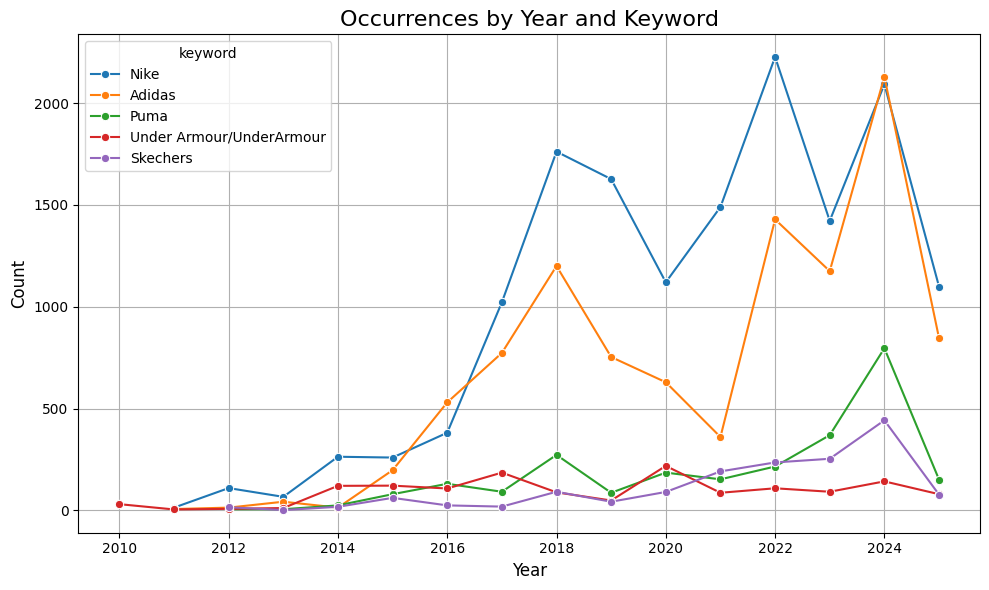

In [16]:

grouped_data = df_filt.groupby(['year', 'keyword']).size().reset_index(name='count').sort_values(by= ['year', 'count'], ascending = False)

plt.figure(figsize=(10, 6))
sns.lineplot(data=grouped_data, x='year', y='count', hue='keyword', marker='o')

# Customize plot
plt.title('Occurrences by Year and Keyword', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.grid(True)
plt.tight_layout()

# Show plot
plt.show()

In [17]:
pivot_df = grouped_data.pivot(index='year', columns='keyword', values='count').fillna(0)
pivot_df

keyword,Adidas,Nike,Puma,Skechers,Under Armour/UnderArmour
year,,,,,
2010,0.0,0.0,0.0,0.0,30.0
2011,6.0,13.0,0.0,0.0,4.0
2012,13.0,109.0,5.0,15.0,7.0
2013,42.0,66.0,5.0,1.0,11.0
2014,13.0,263.0,24.0,17.0,120.0
2015,197.0,259.0,79.0,61.0,121.0
2016,530.0,381.0,130.0,24.0,107.0
2017,773.0,1022.0,91.0,18.0,185.0
2018,1200.0,1762.0,272.0,91.0,88.0


# RAG

## Saving to bucket

In [18]:
# df4['comment_text'].dropna().to_csv('Data for RAG/comments.txt', index=False, header=False, sep='\n')

In [19]:
df_filt['keyword'] = df_filt['keyword'].replace({"Under Armour/UnderArmour": "Under Armour"})
df_filt.keyword.unique()

array(['Nike', 'Puma', 'Under Armour', 'Adidas', 'Skechers'], dtype=object)

In [21]:
# df_filt.to_csv('final.csv')

In [ ]:
# Assuming df is your DataFrame and has 'keyword', 'comment_text', and 'year' columns
keywords = df_filt['keyword'].dropna().unique()  # Get unique keywords from the DataFrame
years = df_filt['year'].dropna().unique()  # Get unique years from the DataFrame

# Define the GCS bucket and folder path where you want to store the files
bucket_name = "<gcp-bucket-name>"
gcs_folder_path = "Data for RAG/"  # Path in GCS

# Initialize Google Cloud Storage client
client = storage.Client()
bucket = client.bucket(bucket_name)

# Loop through each keyword and year to create a text file
for keyword in keywords:
    for year in years:
        # Filter the DataFrame by both keyword and year, then get the corresponding 'comment_text'
        comments = df_filt[(df_filt['keyword'] == keyword) & (df_filt['year'] == year)]['comment_text'].dropna()

        # Only proceed if there are comments for that keyword and year combination
        if not comments.empty:
            # Create a local text file with the keyword and year in the name
            local_filename = f"{keyword.replace(' ', '_')}_{year}.txt"
            
            # Save the comments of that keyword and year to the local text file
            comments.to_csv(local_filename, index=False, header=False, sep='\n')

            # Define the path in GCS where the file will be uploaded
            gcs_file_path = f"{gcs_folder_path}{local_filename}"

            # Create a blob object for the file in GCS
            blob = bucket.blob(gcs_file_path)

            # Upload the local file to GCS
            blob.upload_from_filename(local_filename)

            # Clean up local file
            os.remove(local_filename)

            print(f"TXT file for keyword '{keyword}' and year '{year}' successfully uploaded to GCS: gs://{bucket_name}/{gcs_file_path}")


## RAG Pipeline

In [ ]:
MODEL_ID = "gemini-2.0-flash-001"  # @param {type: "string"}
PROJECT_ID = "<PROJECT_ID>"
LOCATION = "us-central1" 

display_name = "test_corpus"
paths = ["gs://<bucket>/Data for RAG/"]  # Supports Google Cloud Storage and Google Drive Links

In [34]:
vertexai.init(project=PROJECT_ID, location="us-central1")

# Create RagCorpus
# Configure embedding model, for example "text-embedding-004".
embedding_model_config = rag.EmbeddingModelConfig(
  publisher_model="publishers/google/models/text-embedding-004"
)

backend_config = rag.RagVectorDbConfig(rag_embedding_model_config=embedding_model_config)

rag_corpus = rag.create_corpus(
    display_name=display_name,
    backend_config=backend_config,
)

# List the rag corpus you just created
rag_corpus = rag.list_corpora()

In [49]:
# Import Files to the RagCorpus
# choose a corpus to import files to, you can use rag_corpus.name for just created corpus
# or use the name in list_corpora()

for corpus in rag_corpus:
    corpus_name = corpus.name 
    
# corpus_name = rag_corpus.name

transformation_config = rag.TransformationConfig(
      chunking_config=rag.ChunkingConfig(
          chunk_size=512,
          chunk_overlap=100,
      ),
  )

rag.import_files(
    corpus_name,
    paths,
    transformation_config=transformation_config, # Optional
    max_embedding_requests_per_min=1000,  # Optional
)

imported_rag_files_count: 1

In [ ]:
# # Alternatively, you can use async import
# response = await rag.import_files_async(
#   corpus_name,
#   paths,
#   transformation_config=transformation_config, # Optional
#   max_embedding_requests_per_min=1000,  # Optional
# )
# result = await response.result()
# print(result)

In [1]:
# List the files in the rag corpus
rag.list_files(corpus_name)

# Direct context retrieval
rag_retrieval_config=rag.RagRetrievalConfig(
    top_k=5,  # Optional
    filter=rag.Filter(vector_distance_threshold=0.5)  # Optional
)
response = rag.retrieval_query(
    rag_resources=[
        rag.RagResource(
            rag_corpus=corpus_name,
            # Optional: supply IDs from `rag.list_files()`.
            # rag_file_ids=["rag-file-1", "rag-file-2", ...],
        )
    ],
    text="What do people think about Under Armour? Summarize it in 5 bullet points",
    rag_retrieval_config=rag_retrieval_config,
)


In [54]:
# Enhance generation
# Create a RAG retrieval tool
rag_retrieval_tool = Tool.from_retrieval(
    retrieval=rag.Retrieval(
        source=rag.VertexRagStore(
            rag_resources=[
                rag.RagResource(
                    rag_corpus=corpus_name,  # Currently only 1 corpus is allowed.
                    # Optional: supply IDs from `rag.list_files()`.
                    # rag_file_ids=["rag-file-1", "rag-file-2", ...],
                )
            ],
            rag_retrieval_config=rag_retrieval_config,
        ),
    )
)
# Create a gemini model instance
rag_model = GenerativeModel(
    model_name=MODEL_ID, tools=[rag_retrieval_tool]
)

# Generate response
response = rag_model.generate_content("What do people think about Under Armour? Summarize it in 5 bullet points")
print(response.text)

Here's a summary of what people think about Under Armour, based on the provided comments:

*   Some people think Under Armour makes awesome stuff, like metal baseball cleats.
*   Some find Under Armour's clothing decent, and Under Armour makes damn good stuff.
*   There are complaints about the poor fit of Under Armour for larger people.
*   Some find Under Armour expensive, even at the outlet stores.
*   Under Armour is considered uncool by some, with some feeling their cleats are of terrible quality, and Under Armour is for grandpas.
